In [1]:
# import sys
# sys.path.append("../../")
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [2]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGenerator.InputDist.MIXTURE

num_decomps=1
num_subsets=5
num_mixtures=2

# Number of input mixtures for dense generator
num_input_mixtures = 2

### Learning

In [3]:
# Additive smoothing during learning
additive_smoothing=100
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(10, 11)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/jos/datasets/mnist")

Extracting /home/jos/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
def show_mnist(img):
    img=np.reshape(img, (14,14))
    plt.imshow(img, interpolation='none', cmap="gray")
    plt.show()

### Process data

In [5]:
def process_set(data):
#     threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 0.5).ravel()))
    images=np.vstack((resized - np.mean(resized)) / np.std(resized))
    return images

In [6]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

/home/jos/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [ ]:
show_mnist(train_images[19])

In [7]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

In [8]:
print(train_images_0.shape)
show_mnist(train_images_0[334])
print(train_images_1.shape)
show_mnist(train_images_1[22])
print(test_images_0.shape)
show_mnist(test_images_0[334])
print(test_images_1.shape)
show_mnist(test_images_1[22])

NameError: name 'train_images_0' is not defined

# Generate SPN structure

In [8]:
gauss_quantiles = spn.GaussianLeaf(num_vars=196, num_components=2, data=train_images)
# gauss_quantiles.learn_from_data(train_images)
dense_gen = spn.DenseSPNGenerator(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                  input_dist=input_dist, 
                                  num_input_mixtures=num_input_mixtures)
root0 = dense_gen.generate(gauss_quantiles)
root1 = dense_gen.generate(gauss_quantiles)
root = spn.Sum(root0, root1)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

4936


# Add Learning Ops

In [9]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          additive_smoothing=additive_smoothing_var)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:277: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:281: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use the `axis` argument instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/graph/sum.py:298: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


# Run Training

In [10]:
sess=None #https://github.com/whsu/spn/tree/master/spn

In [14]:
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

In [ ]:
train_set = np.concatenate([train_images_0, train_images_1], 0)
train_labels = np.concatenate([np.ones((train_images_0.shape[0]))*0, 
                               np.ones((train_images_1.shape[0]))*1])
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()

sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=32
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0

accumulators = [node.accum for node in learning._gaussian_leaf_nodes]
sum_data = [node.sum_data for node in learning._gaussian_leaf_nodes]
sum_data_squared = [node.sum_data_squared for node in learning._gaussian_leaf_nodes]

while abs(prev_likelihood - likelihood)>0.1:
    prev_likelihood=likelihood
    likelihoods = []
    pbar = tqdm_notebook(range(num_batches))
    train_set, train_labels = shuffle(train_set, train_labels)
    for batch in pbar:
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
#         print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
#         print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _, = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={gauss_quantiles: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
#         print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        pbar.set_description("Lh {}".format(avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
    # Update weights
#     accumulator_val = sess.run(accumulators)
#     sum_data_val = sess.run(sum_data)
#     sum_data_squared_val = sess.run(sum_data_squared)
        sess.run(update_spn)
    
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
#     sess.run(reset_accumulators)

In [14]:
flat_accum = np.concatenate([a.ravel() for a in accumulator_val])
flat_sum_data = np.concatenate([a.ravel() for a in sum_data_val])
flat_sum_data_sq = np.concatenate([a.ravel() for a in sum_data_squared_val])

In [18]:
mean_val = sess.run(gauss_quantiles.variance_variable)
print(np.unique(mean_val))

[-3.9846375  -3.4506104  -3.2645745  -2.6230721  -2.5535667  -2.3906605
 -2.3627794  -2.2616777  -2.0460896  -1.8880049  -1.7511832  -1.6374474
 -1.4197037  -1.4149829  -1.3103653  -1.2638718  -1.2374343  -0.90327877
 -0.78360784 -0.75589406 -0.49836385 -0.42599937 -0.36299995 -0.289812
 -0.26556116 -0.26555693 -0.26555383 -0.26555106 -0.2655483  -0.26554608
 -0.26554334 -0.26553684 -0.26553646 -0.26552987 -0.26551786 -0.2655087
 -0.26549464 -0.26547927 -0.26547578 -0.26546678 -0.26543173 -0.2653948
 -0.26532286 -0.26528108 -0.26524585 -0.26521826 -0.26510143 -0.26503462
 -0.2649982  -0.26485884 -0.26485458 -0.26480815 -0.26473108 -0.2645801
 -0.2644247  -0.2643055  -0.26399818 -0.2639431  -0.26387408 -0.26352537
 -0.26274753 -0.26096758 -0.2594495  -0.25944436 -0.25943905 -0.2594282
 -0.2594237  -0.2594227  -0.2594204  -0.2594177  -0.25934944 -0.25928634
 -0.2592849  -0.25918892 -0.25917885 -0.2591432  -0.25913146 -0.25912598
 -0.2590745  -0.25898182 -0.25887063 -0.2586967  -0.2586741

In [16]:
%matplotlib inline
import seaborn as sns
print(flat_sum_data_sq)
print(np.unique(flat_accum).size)

[ 1484.4747  1682.9863  1484.443   1682.9863  3167.4133     0.
  3167.2332     0.      1484.3992  1682.9547  3166.9387     0.
  3165.7021     0.      1483.6943  1681.1724     0.      3164.8037
  1682.5862  1484.2355  3167.3145     0.      1682.9863  1484.4747
  3167.4612     0.      3167.4612     0.         0.      3167.3857
  3166.802      0.         0.      3166.1055     0.      3161.367
  1458.8612  1676.4113  1633.7145  1395.5635  1489.4539  1264.5713
  1351.8503  1112.4976     0.      2388.4     2595.3616     0.
  2905.9563     0.      3104.45       0.         0.      3162.3135
     0.      3167.353   1682.8475  1484.4747  1483.2852  1681.9614
     0.      3157.4116     0.      3167.709   1669.4047  1685.9297
  4547.487      0.         0.      9528.631  10665.487   5903.5493
  5866.727  11825.605      0.     12743.046   3375.4094  2913.196
  3283.7761     0.         0.      3126.1194  1484.012   1682.9236
     0.      3167.3208     0.      3164.045   1477.3425  1680.3434
  3454.24

# Generate Testing Ops

In [15]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [16]:
mpe_gauss_quantiles, mpe_latent = mpe_state_gen.get_state(root, gauss_quantiles, latent)

# Run Testing

### MPE of the whole network

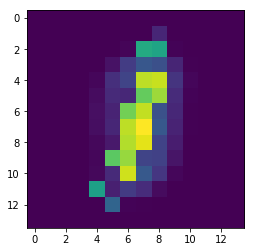

[[1]]


In [17]:
no_evidence = np.zeros((1, 14 * 14)).astype(np.bool) 
mpe_gauss_val, mpe_latent_val = sess.run([mpe_gauss_quantiles, mpe_latent], feed_dict={
    gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[-1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 0

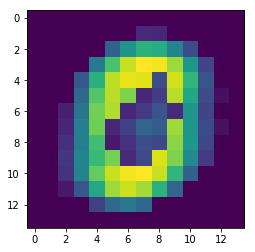

In [20]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[0]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 1

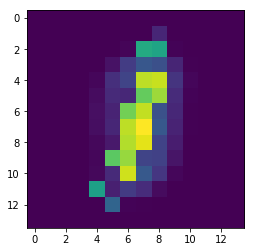

[[1]]


In [21]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### Classification of Training Data

In [22]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={
    gauss_quantiles: train_set, latent: np.ones((train_set.shape[0], 1))*-1})
result=(mpe_latent_val==train_labels)
np.sum(result) / train_labels.size

0.9960423298632023

### Classification of Test Data

In [42]:
test_set = np.concatenate([test_images_0, test_images_1], 0)
test_labels = np.concatenate([np.ones((test_images_0.shape[0]))*0, 
                               np.ones((test_images_1.shape[0]))*1])
test_labels=np.reshape(test_labels, (-1, 1))

In [43]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: test_set, 
                                                   latent: np.ones((test_set.shape[0], 1))*-1})
result=(mpe_latent_val==test_labels)
np.sum(result) / test_labels.size

0.99763593380614657